In [1]:
import os, re, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from iEEG_helper_functions import *

In [2]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"

In [3]:
# # Initialize an empty list to hold the data
# # completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
# completed_hup_ids = [
#     160,
#     172,
#     # 141, # not enough time before first seizure
#     145,
#     138,
#     142,
#     151,
#     187,
#     180,
#     184,
#     # 192, # incomplete data
#     # 196, # not enough time before first seizure
#     # 204, # not enough time before first seizure
#     # 165, # incomplete data
#     # 169, # not enough time after the last seizure
#     173,
#     # 150, # not enough time before first seizure
#     # 154, # incomplete data
#     # 158, # incomplete data
#     # 207, # not enough time before first seizure
#     223,
#     # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
#     # 196, # not enough time before first seizure
#     # 204, # not enough time before first seizure
#     177,
#     185,
#     # 189, # not enough time before first seizure
#     # 205, # not enough time before first seizure
#     166,
#     # 170, # not enough time before first seizure
#     # 174, # not enough time before first seizure
# ]
# # Sort completed_hup_ids in ascending order
# completed_hup_ids.sort()

In [4]:
patient_hup_id = 143
fs = 1024

In [5]:
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP143_phaseII_150.npy,150,18432000
1,HUP143_phaseII_156.npy,156,19169280
2,HUP143_phaseII_157.npy,157,19292160
3,HUP143_phaseII_158.npy,158,19415040
4,HUP143_phaseII_159.npy,159,19537920
...,...,...,...
6694,HUP143_phaseII_7163.npy,7163,880189440
6695,HUP143_phaseII_7164.npy,7164,880312320
6696,HUP143_phaseII_7165.npy,7165,880435200
6697,HUP143_phaseII_7166.npy,7166,880558080


In [6]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index_samples", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index_samples,channel_index,sequence_index
0,18463258,0,0
1,18463258,2,0
2,18463258,1,0
3,18500815,0,1
4,18500815,2,1
...,...,...,...
288922,880797717,2,52
288923,880798082,0,53
288924,880798085,1,53
288925,880802131,1,54


In [7]:
filename = f"HUP{patient_hup_id}_phaseII_hr_66_fs_{fs}.pkl"
# Get the full path to the file
full_path = os.path.join(IEEG_DIRECTORY, filename)

with open(full_path, "rb") as f:
    ieeg_data = pickle.load(f)

all_channel_labels = ieeg_data.columns.values.astype(str)
label_idxs = electrode_selection(all_channel_labels)
labels = all_channel_labels[label_idxs]
good_channels_res = detect_bad_channels_optimized(ieeg_data[labels].to_numpy(), fs)
good_channel_indicies = good_channels_res[0]
good_labels = labels[good_channel_indicies]

In [8]:
soz_channel_labels = [
    "LB01",
    "LB02",
    "LB03",
    "LB04",
    "LB05",
    "LB06",
    "LB07",
    "LA01",
    "LA02",
    "LA03",
    "LA04",
    "LA05",
    "RD03",
    "RA01",
    "RA02",
]
soz_channel_labels = np.array(soz_channel_labels)

In [9]:
all_spikes_df["channel_label"] = all_spikes_df["channel_index"].map(
    lambda x: good_labels[x]
)
all_spikes_df["is_soz"] = all_spikes_df["channel_label"].isin(soz_channel_labels)

# Add a column called peak_time_microseconds
all_spikes_df["peak_time_microseconds"] = (
    all_spikes_df["peak_index_samples"] / fs * 1e6
).astype(int)

# Reorder the columns to be peak_index_samples, channel_index, channel_label, is_soz, sequence_index
all_spikes_df = all_spikes_df[
    [
        "peak_index_samples",
        "peak_time_microseconds",
        "channel_index",
        "channel_label",
        "is_soz",
        "sequence_index",
    ]
]

all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,sequence_index
0,18463258,18030525390,0,LA01,True,0
1,18463258,18030525390,2,LA03,True,0
2,18463258,18030525390,1,LA02,True,0
3,18500815,18067202148,0,LA01,True,1
4,18500815,18067202148,2,LA03,True,1
...,...,...,...,...,...,...
288922,880797717,860154020507,2,LA03,True,52
288923,880798082,860154376953,0,LA01,True,53
288924,880798085,860154379882,1,LA02,True,53
288925,880802131,860158331054,1,LA02,True,54


In [10]:
# Calculate the inter-spike interval
all_spikes_df.loc[:, "inter_spike_interval_samples"] = all_spikes_df[
    "peak_index_samples"
].diff()

# Convert the inter_spike_interval_samples column to integer
all_spikes_df.loc[:, "inter_spike_interval_samples"] = (
    all_spikes_df["inter_spike_interval_samples"].fillna(0).astype(int)
)

all_spikes_df

/tmp/ipykernel_54087/3720138829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_spikes_df.loc[:, "inter_spike_interval_samples"] = all_spikes_df[
/tmp/ipykernel_54087/3720138829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_spikes_df.loc[:, "inter_spike_interval_samples"] = (
/tmp/ipykernel_54087/3720138829.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use ei

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,sequence_index,inter_spike_interval_samples
0,18463258,18030525390,0,LA01,True,0,0
1,18463258,18030525390,2,LA03,True,0,0
2,18463258,18030525390,1,LA02,True,0,0
3,18500815,18067202148,0,LA01,True,1,37557
4,18500815,18067202148,2,LA03,True,1,0
...,...,...,...,...,...,...,...
288922,880797717,860154020507,2,LA03,True,52,74
288923,880798082,860154376953,0,LA01,True,53,365
288924,880798085,860154379882,1,LA02,True,53,3
288925,880802131,860158331054,1,LA02,True,54,4046


In [11]:
threshold = np.exp(5)
threshold

148.4131591025766

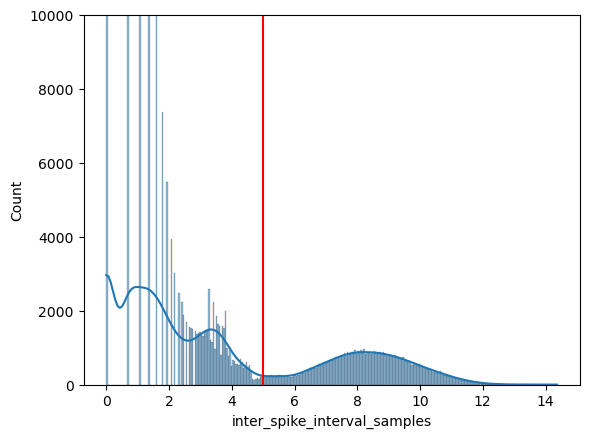

In [12]:
log_data = np.log(
    all_spikes_df[all_spikes_df["inter_spike_interval_samples"] > 0][
        "inter_spike_interval_samples"
    ]
)

sns.histplot(log_data, kde=True, bins=300)
# set y limit
plt.ylim(0, 10000)
# plot a vertical red line at x = threshold[0]
plt.axvline(x=np.log(threshold), color="red")

In [13]:
# Check for sequence change based on sequence_index or inter_spike_interval_samples
change_mask = (all_spikes_df["sequence_index"].diff() != 0) | (
    all_spikes_df["inter_spike_interval_samples"] > threshold
)

# Create the sequence_index_mask
all_spikes_df["sequence_index_mask"] = change_mask.astype(int).cumsum()

/tmp/ipykernel_54087/217808277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_spikes_df["sequence_index_mask"] = change_mask.astype(int).cumsum()


In [14]:
all_spikes_df.head(50)

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,sequence_index,inter_spike_interval_samples,sequence_index_mask
0,18463258,18030525390,0,LA01,True,0,0,1
1,18463258,18030525390,2,LA03,True,0,0,1
2,18463258,18030525390,1,LA02,True,0,0,1
3,18500815,18067202148,0,LA01,True,1,37557,2
4,18500815,18067202148,2,LA03,True,1,0,2
5,18500815,18067202148,1,LA02,True,1,0,2
6,18510874,18077025390,2,LA03,True,2,10059,3
7,18510874,18077025390,0,LA01,True,2,0,3
8,18510874,18077025390,1,LA02,True,2,0,3
9,18549988,18115222656,2,LA03,True,3,39114,4


In [15]:
# Drop the sequence_index column
all_spikes_df = all_spikes_df.drop(columns=["sequence_index"])
# Rename the sequence_index_mask column to sequence_index
all_spikes_df = all_spikes_df.rename(columns={"sequence_index_mask": "sequence_index"})
all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index
0,18463258,18030525390,0,LA01,True,0,1
1,18463258,18030525390,2,LA03,True,0,1
2,18463258,18030525390,1,LA02,True,0,1
3,18500815,18067202148,0,LA01,True,37557,2
4,18500815,18067202148,2,LA03,True,0,2
...,...,...,...,...,...,...,...
288922,880797717,860154020507,2,LA03,True,74,73309
288923,880798082,860154376953,0,LA01,True,365,73310
288924,880798085,860154379882,1,LA02,True,3,73310
288925,880802131,860158331054,1,LA02,True,4046,73311


In [16]:
all_spikes_df.head(20)

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index
0,18463258,18030525390,0,LA01,True,0,1
1,18463258,18030525390,2,LA03,True,0,1
2,18463258,18030525390,1,LA02,True,0,1
3,18500815,18067202148,0,LA01,True,37557,2
4,18500815,18067202148,2,LA03,True,0,2
5,18500815,18067202148,1,LA02,True,0,2
6,18510874,18077025390,2,LA03,True,10059,3
7,18510874,18077025390,0,LA01,True,0,3
8,18510874,18077025390,1,LA02,True,0,3
9,18549988,18115222656,2,LA03,True,39114,4


In [17]:
# Adding is_leader column
all_spikes_df["is_leader"] = ~all_spikes_df["sequence_index"].duplicated(keep="first")
all_spikes_df

,peak_index_samples,peak_time_microseconds,channel_index,channel_label,is_soz,inter_spike_interval_samples,sequence_index,is_leader
0,18463258,18030525390,0,LA01,True,0,1,True
1,18463258,18030525390,2,LA03,True,0,1,False
2,18463258,18030525390,1,LA02,True,0,1,False
3,18500815,18067202148,0,LA01,True,37557,2,True
4,18500815,18067202148,2,LA03,True,0,2,False
...,...,...,...,...,...,...,...,...
288922,880797717,860154020507,2,LA03,True,74,73309,False
288923,880798082,860154376953,0,LA01,True,365,73310,True
288924,880798085,860154379882,1,LA02,True,3,73310,False
288925,880802131,860158331054,1,LA02,True,4046,73311,True


In [18]:
# Save the DataFrame to an csv file
all_spikes_df.to_csv(f"../../Public/spikes/HUP_{patient_hup_id}.csv", index=False)